# A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 1: Data pre-processing**  
Procedures:  
&nbsp; 1): Read the dataset读取数据  
&nbsp; 2): Transform the tabular data into images表格数据转为图像数据  
&nbsp; 3): Display the transformed images展示转换后的图像数据  
&nbsp; 4): Split the training and test set划分训练集和测试集  

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

## Read the Car-Hacking/CAN-Intrusion dataset
The complete Car-Hacking dataset is publicly available at: https://ocslab.hksecurity.net/Datasets/CAN-intrusion-dataset  
In this repository, due to the file size limit of GitHub, we use the 5% subset.

由于Github限制文件大小,所以仅使用5%文件.

In [3]:
#Read dataset
# 我是直接读取作者GitHub上的csv文件,当然也可以下载到本地再传到colab再跑
df=pd.read_csv('https://raw.githubusercontent.com/Western-OC2-Lab/Intrusion-Detection-System-Using-CNN-and-Transfer-Learning/refs/heads/main/data/Car_Hacking_5%25.csv')

In [5]:
df

,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,1201,41,39,39,35,0,0,0,154,R
1,809,64,187,127,20,17,32,0,20,R
2,1349,216,0,0,136,0,0,0,0,R
3,1201,41,39,39,35,0,0,0,154,R
4,2,0,0,0,0,0,3,2,228,R
...,...,...,...,...,...,...,...,...,...,...
818435,848,5,32,52,104,117,0,0,12,R
818436,1088,255,0,0,0,255,134,9,0,R
818437,848,5,32,100,104,117,0,0,92,R
818438,1349,216,90,0,137,0,0,0,0,R


In [6]:
# The labels of the dataset. "R" indicates normal patterns, and there are four types of attack (DoS, fuzzy. gear spoofing, and RPM spoofing zttacks)
# R表示正常样本,其他四种都是攻击类型样本
df.Label.value_counts()

,count
Label,
R,701832
RPM,32539
gear,29944
DoS,29501
Fuzzy,24624


In [10]:
df.info() #查看data的数据类型

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818440 entries, 0 to 818439
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   CAN ID   818440 non-null  float64
 1   DATA[0]  818440 non-null  float64
 2   DATA[1]  818440 non-null  float64
 3   DATA[2]  818440 non-null  float64
 4   DATA[3]  818440 non-null  float64
 5   DATA[4]  818440 non-null  float64
 6   DATA[5]  818440 non-null  float64
 7   DATA[6]  818440 non-null  float64
 8   DATA[7]  818440 non-null  float64
 9   Label    818440 non-null  object 
dtypes: float64(9), object(1)
memory usage: 62.4+ MB


## Data Transformation
Convert tabular data to images
Procedures:
1. Use quantile transform(分位数变换) to transform the original data samples into the scale of [0,255], representing pixel values(像素值)
2. Generate images for each category (Normal, DoS, Fuzzy, Gear, RPM), each image consists of 27 data samples with 9 features. Thus, the size of each image is 9*9*3, length 9, width 9, and 3 color channels (RGB).

  生成的图片数据按攻击类型进行分类,每张图片包含27个样本和9个特征;每张图片数据的大小是9*9*3

In [11]:
# Transform all features into the scale of [0,1]
numeric_features = df.dtypes[df.dtypes != 'object'].index #获取列类型是object之外的所有列；  这里想做的就是将label剔除，好做quantile transform
print(numeric_features)
scaler = QuantileTransformer() #实例化
df[numeric_features] = scaler.fit_transform(df[numeric_features])
print(df[numeric_features]) #查看效果

Index(['CAN ID', 'DATA[0]', 'DATA[1]', 'DATA[2]', 'DATA[3]', 'DATA[4]',
       'DATA[5]', 'DATA[6]', 'DATA[7]'],
      dtype='object')
          CAN ID   DATA[0]   DATA[1]   DATA[2]   DATA[3]   DATA[4]   DATA[5]  \
0       0.902402  0.700200  0.634635  0.696697  0.584084  0.000000  0.000000   
1       0.607107  0.718719  0.972472  0.886386  0.507007  0.520020  0.506006   
2       0.960961  0.845846  0.000000  0.000000  0.742743  0.000000  0.000000   
3       0.902402  0.700200  0.634635  0.696697  0.584084  0.000000  0.000000   
4       0.055055  0.000000  0.000000  0.000000  0.000000  0.000000  0.410410   
...          ...       ...       ...       ...       ...       ...       ...   
818435  0.655155  0.424424  0.443944  0.710711  0.674174  0.795295  0.000000   
818436  0.865866  1.000000  0.000000  0.000000  0.000000  1.000000  0.808809   
818437  0.655155  0.424424  0.443944  0.826326  0.674174  0.795295  0.000000   
818438  0.960961  0.845846  0.813313  0.000000  0.748749  0.00000

In [12]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(lambda x: (x*255)) #将数据映射到0-255范围内,因为像素值是0-255

In [14]:
df.describe() #查看统计信息   （检验数据处理是否有问题） 主要看min和max

,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7]
count,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000
mean,125.866069,113.185476,107.369659,89.119321,109.652648,104.908332,111.779495,85.091641,93.346828
std,74.524839,89.890894,93.189413,100.269144,103.582102,95.246744,90.636415,101.501461,100.448233
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.430931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,119.587087,125.202703,113.205706,0.000000,129.286787,126.223724,129.031532,0.000000,0.000000
75%,189.909910,192.590090,192.590090,198.460961,190.930931,191.696697,188.761261,192.972973,191.951952
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


All features are in the same scale of [0,255]

### Generate images for each class

In [15]:
# 将整个data按攻击类别进行分类,一共5类
# 分类后同时删除标签
df0=df[df['Label']=='R'].drop(['Label'],axis=1)
df1=df[df['Label']=='RPM'].drop(['Label'],axis=1)
df2=df[df['Label']=='gear'].drop(['Label'],axis=1)
df3=df[df['Label']=='DoS'].drop(['Label'],axis=1)
df4=df[df['Label']=='Fuzzy'].drop(['Label'],axis=1)

In [20]:
ims = []
im = df0.iloc[0].values
ims = np.append(ims,im)
print(ims,'\n')
im2 = df0.iloc[1].values
ims = np.append(ims,im2)
print(ims)

[230.11261261 178.55105105 161.83183183 177.65765766 148.94144144
   0.           0.           0.         216.32882883] 

[230.11261261 178.55105105 161.83183183 177.65765766 148.94144144
   0.           0.           0.         216.32882883 154.81231231
 183.27327327 247.98048048 226.02852853 129.28678679 132.60510511
 129.03153153   0.         153.53603604]


In [21]:
# Generate 9*9 color images for class 0 (Normal)
# 开始转换成图像数据, 这里是正常样本转换
count=0
ims = []

image_path = "train_data/normal/" # 创建一个目录（文件夹）
os.makedirs(image_path)
# 将27行数据全部塞到一个list里面,然后再利用reshape重塑成9*9*3的数组,再转换成图片
for i in range(0, len(df0)):
    count=count+1
    if count<=27:
        im=df0.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8) # 图像数据通常以8位无符号整数（uint8）的形式存储
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

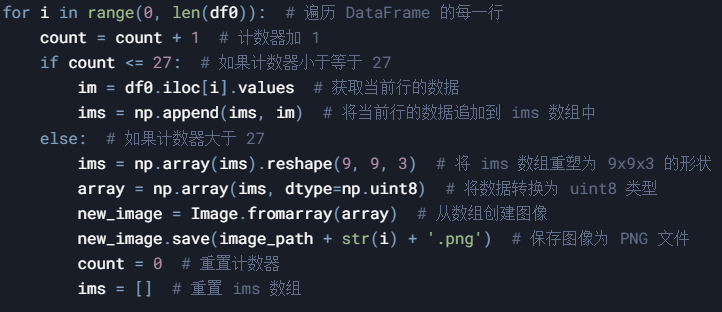

In [22]:
# Generate 9*9 color images for class 1 (RPM spoofing)
count=0
ims = []

image_path = "train_data/RPM_spoofing/"
os.makedirs(image_path)

for i in range(0, len(df1)):
    count=count+1
    if count<=27:
        im=df1.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [23]:
# Generate 9*9 color images for class 2 (Gear spoofing)
count=0
ims = []

image_path = "train_data/Gear_spoofing/"
os.makedirs(image_path)

for i in range(0, len(df2)):
    count=count+1
    if count<=27:
        im=df2.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [24]:
# Generate 9*9 color images for class 3 (DoS attack)
count=0
ims = []

image_path = "train_data/Dos/"
os.makedirs(image_path)


for i in range(0, len(df3)):
    count=count+1
    if count<=27:
        im=df3.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [25]:
# Generate 9*9 color images for class 4 (Fuzzy attack)
count=0
ims = []

image_path = "train_data/Fuzzy/"
os.makedirs(image_path)


for i in range(0, len(df4)):
    count=count+1
    if count<=27:
        im=df4.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

## Split the training and test set

In [26]:
# Create folders to store images
Train_Dir='./train_data/'
Val_Dir='./test_data/'
allimgs=[]

# 因为目录中又包含子目录....,所以用多层for语句实现所有路径遍历
for subdir in os.listdir(Train_Dir):  #os.listdir()用于列出指定目录中的所有文件和子目录
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename) # os.path.join()用于智能地拼接路径
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

29228


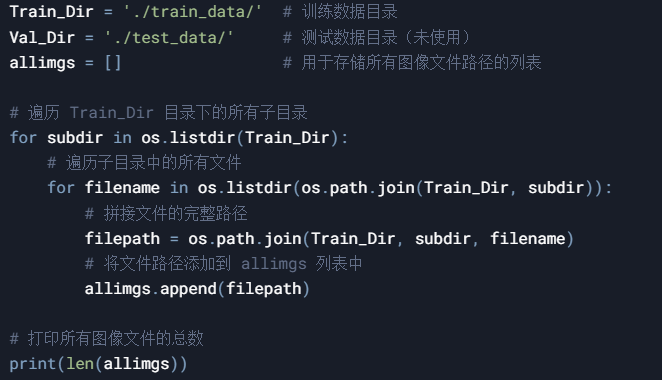

In [27]:
#split a test set from the dataset, train/test size = 80%/20%
# 划分数据集：训练/测试 = 82开
Numbers=len(allimgs)//5 	#size of test set (20%)   整除5

# 将文件从源路径srcfile移动到目标路径dstfile。这个函数会检查源文件是否存在，并在目标路径不存在时自动创建目标目录
def mymovefile(srcfile,dstfile):
    # 检查源文件是否存在
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        # 分割目标路径，获取目录和文件名
        fpath,fname=os.path.split(dstfile)
        # 如果目标目录不存在，则创建它
        if not os.path.exists(fpath):
            os.makedirs(fpath)
        # 移动文件
        shutil.move(srcfile,dstfile)
        #print ("move %s -> %s"%(srcfile,dstfile))

In [28]:
# The size of test set
Numbers

5845

In [29]:
# Create the test set
#从allimgs列表中随机选择一部分图像文件，并将这些图像文件从训练集目录移动到测试集目录。以下是代码的详细解释：

val_imgs=random.sample(allimgs,Numbers) #用于从序列（如列表、元组或字符串）中随机选择指定数量的元素，且不会重复选择
# Val_Dir='./test_data/'
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir) # 将路径中的训练集目录替换为测试集目录  Val_Dir在上面已经定义了
    mymovefile(img,dest_path) # 移动文件
print('Finish creating test set')
# 转移后的数据不会保留在 Train_Dir 中，而是从 Train_Dir 中删除并移动到 Val_Dir 中

Finish creating test set


CNN（卷积神经网络）在处理224x224大小的图片时表现非常出色，尤其是在图像分类、目标检测和图像分割等任务中。

许多经典的CNN架构（如 AlexNet、VGG、ResNet 等）都使用224x224作为输入尺寸。

In [30]:
#resize the images 224*224 for better CNN training
#将指定文件夹中的所有图像文件调整为 224x224 的尺寸，并将调整后的图像保存到目标文件夹中
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

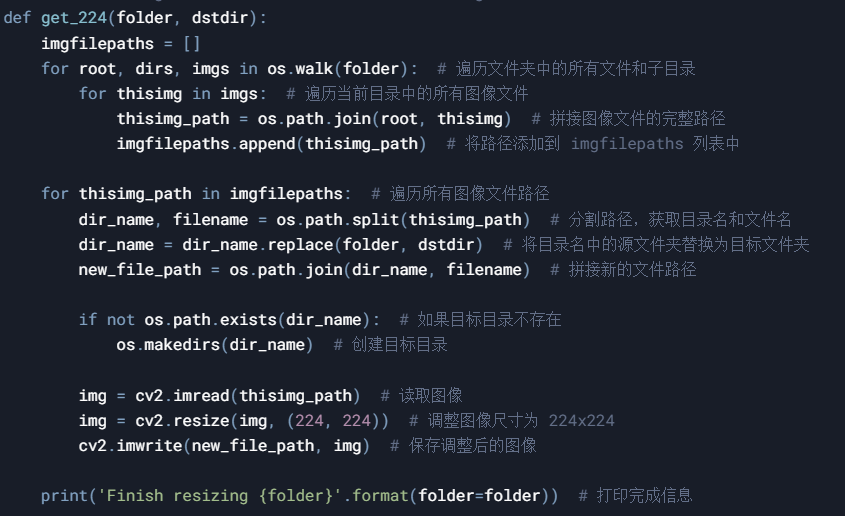

In [32]:
DATA_DIR_224='./train_data_224/'
get_224(folder='./train_data/',dstdir=DATA_DIR_224)

Finish resizing


In [33]:
DATA_DIR2_224='./test__data224/'
get_224(folder='./test_data/',dstdir=DATA_DIR2_224)

Finish resizing


### Display samples for each category

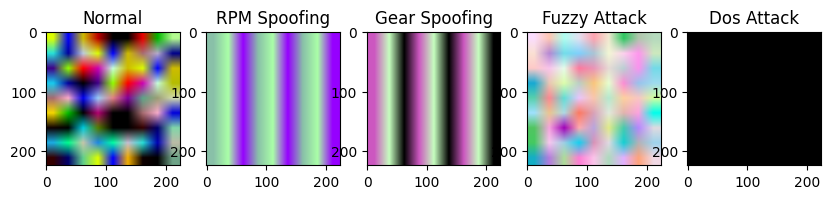

In [39]:
# Read the images for each category, the file name may vary (27.png, 83.png...)
img1 = Image.open('./train_data_224/normal/100239.png')
img2 = Image.open('./train_data_224/RPM_spoofing/10023.png')
img3 = Image.open('./train_data_224/Gear_spoofing/10023.png')
img4 = Image.open('./train_data_224/Fuzzy/10023.png')
img5 = Image.open('./train_data_224/Dos/1007.png')

plt.figure(figsize=(10, 10))
plt.subplot(1,5,1)
plt.imshow(img1)
plt.title("Normal")
plt.subplot(1,5,2)
plt.imshow(img2)
plt.title("RPM Spoofing")
plt.subplot(1,5,3)
plt.imshow(img3)
plt.title("Gear Spoofing")
plt.subplot(1,5,4)
plt.imshow(img4)
plt.title("Fuzzy Attack")
plt.subplot(1,5,5)
plt.imshow(img5)
plt.title("Dos Attack")
plt.show()  # display it